In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
word2vec = {}

In [5]:
with open(os.path.join('glove.6B/glove.6B.100d.txt'),encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('total words in embeddings is: ',len(word2vec))

total words in embeddings is:  400004


In [6]:
train = pd.read_csv('toxic_comments/train.csv')

In [7]:
train.shape

(159571, 8)

In [8]:
train.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
24097,3faaedf63d2e74da,Adopt a user \n\nHi there; you are on the page...,0,0,0,0,0,0
35230,5e15edc368dbeaef,"""\n\n Scarborough Nicknames \n\nWhile I don't ...",0,0,0,0,0,0
129151,b2b692bb1b91f47c,Why did you revert my edit\nI'm at a loss to e...,0,0,0,0,0,0
132158,c337f553781fbac3,still don't see how that is wrong. it was a re...,0,0,0,0,0,0
101293,1e352433ffb0aa9c,Just seems like a colossal disruptive editing ...,0,0,0,0,0,0


In [9]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [10]:
comments = train["comment_text"]

In [11]:
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
targets = train[label_cols]

In [12]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)

In [13]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 1400
min sequence length: 0
median sequence length: 35


In [14]:
word_to_index = tokenizer.word_index

In [15]:
len(word_to_index)

210337

In [16]:
sequences_len = [len(sequence) for sequence in sequences]

In [17]:
np.mean(sequences_len)

65.41466181198338

In [18]:
sequences = pad_sequences(sequences,maxlen=100)

In [19]:
num_words = min(20000, len(word2vec)+1)

In [20]:
embedding_matrix = np.zeros((num_words,100))

In [21]:
for word,i in word_to_index.items():
    if i < num_words:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [22]:
embedding_layer = Embedding(
  20000,
  100,
  weights=[embedding_matrix],
  input_length=100,
  trainable=False
)

W0801 17:30:57.871226  4040 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [23]:
input_layer = Input(shape=(100,))
x = embedding_layer(input_layer)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(label_cols), activation='sigmoid')(x)
    

W0801 17:31:00.174094  4040 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 17:31:00.185604  4040 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 17:31:00.195580  4040 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0801 17:31:00.195580  4040 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0801 17:31:00.262401  4040 deprecation_wrapper.py:119] From C:\Pro

In [24]:
model = Model(input_layer, output)

In [25]:
model.compile('adam','binary_crossentropy',metrics=['accuracy'])

W0801 17:31:02.328823  4040 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0801 17:31:02.350915  4040 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
r = model.fit(sequences,targets,batch_size=128,epochs=5,validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 97s 759us/step - loss: 0.0684 - acc: 0.9767 - val_loss: 0.0685 - val_acc: 0.9769
Epoch 2/5
127656/127656 [==============================] - 94s 735us/step - loss: 0.0623 - acc: 0.9783 - val_loss: 0.0654 - val_acc: 0.9778
Epoch 3/5
127656/127656 [==============================] - 93s 729us/step - loss: 0.0582 - acc: 0.9793 - val_loss: 0.0659 - val_acc: 0.9771
Epoch 4/5
127656/127656 [==============================] - 52s 411us/step - loss: 0.0538 - acc: 0.9805 - val_loss: 0.0740 - val_acc: 0.9758
Epoch 5/5
127656/127656 [==============================] - 46s 362us/step - loss: 0.0502 - acc: 0.9815 - val_loss: 0.0699 - val_acc: 0.9759


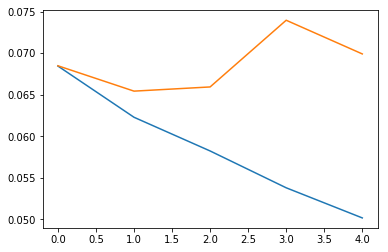

In [34]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='validation loss')

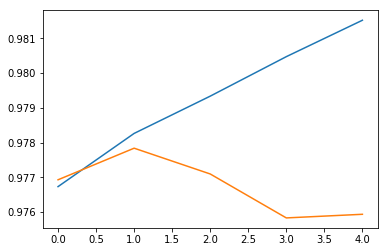

In [35]:
plt.plot(r.history['acc'],label='accuracy')
plt.plot(r.history['val_acc'],label = 'validation history')

In [37]:
predictions = model.predict(sequences)